Current workflow

In [60]:
%pylab inline
# comment on lofi screen
%config InlineBackend.figure_format = 'retina'
import lib
lib.cmdstan_path('~/cmdstan-2.17.0');

Populating the interactive namespace from numpy and matplotlib


## Run Stan model

Compile first,

In [80]:
lib.compile_model('vep-fe-rev-05.stan')

--- Translating Stan model to C++ code ---
bin/stanc  /Users/maedoc/Sources/TVB/VEP/vep-fe-rev-05.stan --o=/Users/maedoc/Sources/TVB/VEP/vep-fe-rev-05.hpp
Model name=vep_fe_rev_05_model
Input file=/Users/maedoc/Sources/TVB/VEP/vep-fe-rev-05.stan
Output file=/Users/maedoc/Sources/TVB/VEP/vep-fe-rev-05.hpp

--- Linking C++ model ---
clang++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.64.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -I src -I stan/src -isystem stan/lib/stan_math/ -DEIGEN_NO_DEBUG -DFUSION_MAX_VECTOR_SIZE=12 -stdlib=libc++ -Wno-unknown-warning-option -Wno-unused-function -Wno-tautological-compare -Wsign-compare -DNO_FPRINTF_OUTPUT -pipe   -O3 -o /Users/maedoc/Sources/TVB/VEP/vep-fe-rev-05 src/cmdstan/main.cpp -include /Users/maedoc/Sources/TVB/VEP/vep-fe-rev-05.hpp stan/lib/stan_math/lib/cvodes_2

Run multiple chains,

In [83]:
%%bash
model=vep-fe-rev-05
rm -f ${model}.*.{out,csv}
for i in 1 2
do
    ./$model id=$i\
        sample save_warmup=1 num_warmup=200 num_samples=200 \
        data file=data.R \
        output file=${model}.$i.csv refresh=10 &> ${model}.$i.out &
done

Check status..

In [84]:
!tail -n 1 vep-fe-rev-05.*.out
csv = lib.parse_csv('vep-fe-rev-05.*.csv', merge=False)

==> vep-fe-rev-05.1.out <==


==> vep-fe-rev-05.2.out <==



IndexError: list index out of range

Maybe stop them if required..

In [82]:
!killall vep-fe-rev-05

## Post process

### HMC

Plot HMC stats (while running)

/Users/maedoc/miniconda3/envs/scipy/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


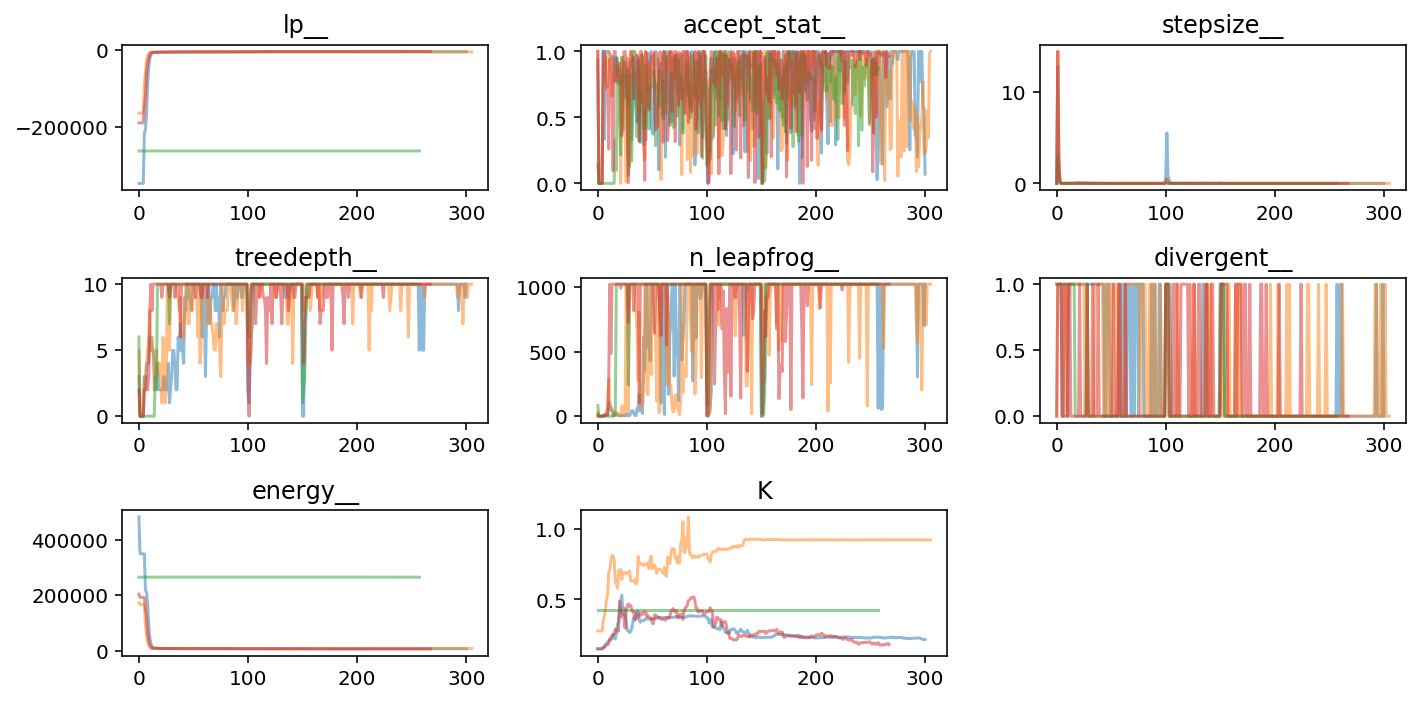

In [72]:
figure(figsize=(10, 5))
skip = 0
for csvi in csv:
    i = 1
    for key in csvi.keys():
        if key[-2:] == '__' or key == 'K':
            subplot(3, 3, i)
            plot(csvi[key][skip:], alpha=0.5)
            title(key)
            i += 1
tight_layout()

### Phase spaces

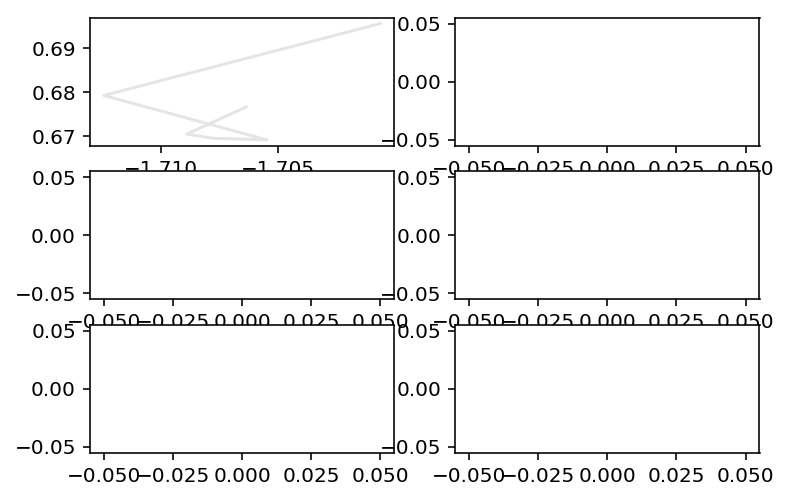

In [76]:
x, z = csv[0]['x'], csv[0]['z']
for i in range(6):
    subplot(3, 2, i + 1)
    x_ = x[:10, i]
    z_ = z[:10, i]
    plot(x_, z_, 'k', alpha=0.1)

In [77]:
x_, z_

(array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]]),
 array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]]))